# Object Detection with Image or Webcam on Ryzen AI

This example demonstrates the object detection model inference on the embedded Neural Processing Unit (NPU) in your AMD Ryzen AI enabled PC with either single image or the live webcam. 

In [32]:
# Before starting, be sure you've installed the requirements listed in the requirements.txt file:
!python -m pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Get Model from Ryzen AI model zoo
The yolov8 model from [Ryzen AI model zoo](https://huggingface.co/amd) will be applied in this example. You may choose any other object detection models with tiny difference in the pre and post processing.

In [33]:
import sys
import os

sys.path.append(os.path.abspath('../RyzenAI-SW/tutorial/yolov8/yolov8_python'))

import torch
import torch.nn as nn
import onnxruntime
import numpy as np
import cv2
import random
from huggingface_hub import hf_hub_download
from yolov8_utils import get_directories, non_max_suppression, plot_images, output_to_target
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Notebook 
# dependencies
from huggingface_hub import hf_hub_download
from yolov8_utils import get_directories

current_dir = get_directories()

# Download Yolov8 model from Ryzen AI model zoo. Registration is required before download.
hf_hub_download(repo_id="amd/yolov8m", filename="yolov8m.onnx", local_dir=str(current_dir))




'C:\\Users\\isaia\\Hackathon\\RyzenAI-SW\\tutorial\\yolov8\\yolov8_python\\yolov8m.onnx'

### 3. Model inference on NPU with webcam

Now we have validated the the model with image., and we will use the webcam as live input to do the inference on NPU.

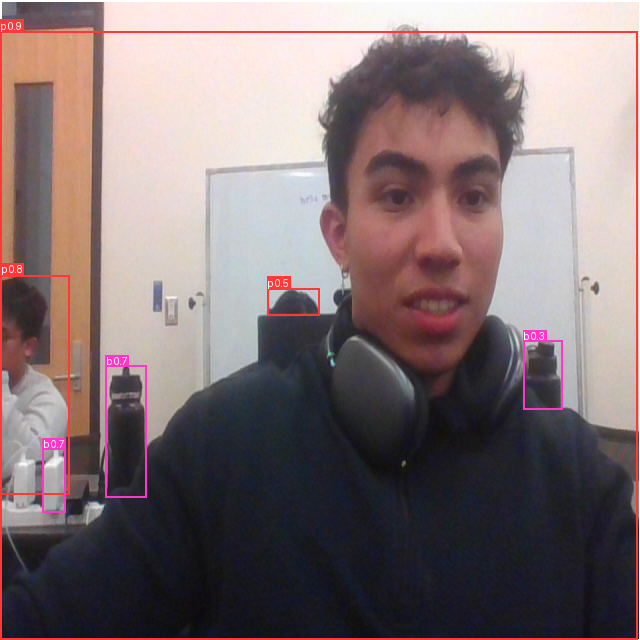

In [ ]:
import sys
import os


sys.path.append(os.path.abspath('../RyzenAI-SW/tutorial/yolov8/yolov8_python'))

import torch
import torch.nn as nn
import onnxruntime
import numpy as np
import cv2
import random
from huggingface_hub import hf_hub_download
from yolov8_utils import get_directories, non_max_suppression, plot_images, output_to_target
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Notebook dependencies
current_dir = get_directories()

# Download Yolov8 model from Ryzen AI model zoo. Registration is required before download.
onnx_model_path = hf_hub_download(repo_id="amd/yolov8m", filename="yolov8m.onnx", local_dir=str(current_dir))

# Load labels of coco dataset
coco_names_path = '../RyzenAI-SW/tutorial/yolov8/yolov8_python/coco.names'
with open(coco_names_path, 'r') as f:
    names = f.read()

imgsz = [640, 640]

# Point to the config file path used for the VitisAI Execution Provider
config_file_path = "./vaip_config.json"

npu_options = onnxruntime.SessionOptions()

npu_session = onnxruntime.InferenceSession(
    onnx_model_path,
    providers = ['VitisAIExecutionProvider'],
    sess_options=npu_options,
    provider_options=[{'config_file': config_file_path}]
)

# Paths to anchors and strides files
anchors_path = '../RyzenAI-SW/tutorial/yolov8/yolov8_python/anchors.npy'
strides_path = '../RyzenAI-SW/tutorial/yolov8/yolov8_python/strides.npy'

def post_process(x):
    dfl = DFL(16)
    anchors = torch.tensor(
        np.load(
            anchors_path,
            allow_pickle=True,
        )
    )
    strides = torch.tensor(
        np.load(
            strides_path,
            allow_pickle=True,
        )
    )
    box, cls = torch.cat([xi.view(x[0].shape[0], 144, -1) for xi in x], 2).split(
        (16 * 4, 80), 1
    )
    dbox = dist2bbox(dfl(box), anchors.unsqueeze(0), xywh=True, dim=1) * strides
    y = torch.cat((dbox, cls.sigmoid()), 1)
    return y, x

# Video input
cap = cv2.VideoCapture(0)

while (True):
    try:
        clear_output(wait=True)
        ret, frame = cap.read()
        
        if not ret:
            break
            
        input_shape = (640, 640)

        im = frame_process(frame, input_shape)
        if len(im.shape) == 3:
            im = im[None]
        outputs = npu_session.run(None, {npu_session.get_inputs()[0].name: im.permute(0, 2, 3, 1).cpu().numpy()})

        # Postprocessing
        outputs = [torch.tensor(item).permute(0, 3, 1, 2) for item in outputs]
        preds = post_process(outputs)
        preds = non_max_suppression(
            preds, 0.25, 0.7, agnostic=False, max_det=300, classes=None
        )

        colors = [[random.randint(0, 255) for _ in range(3)] 
                for _ in range(len(names))]

        plot_images(
        im,
        *output_to_target(preds, max_det=15),
        frame,
        fname="output.jpg",
        names=names,
        )
        
    except KeyboardInterrupt:
        cap.release()